In [3]:
import os
import sys
work_dir = '/home/abhijit/nat/Object-Detection'
data_dir = work_dir+'/data/'
util_dir = work_dir+'/data_utilities/'
os.chdir(work_dir)
sys.path.append(util_dir)
sys.path.append(data_dir)

import wv_util as wv
import matplotlib.pyplot as plt
import numpy as np
import csv
%matplotlib inline
from PIL import Image, ImageDraw 
from tqdm import tqdm
import pickle
import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from matplotlib.lines import Line2D
import pandas as pd
from read_write import *
import shutil
from torch.utils.data import random_split

In [4]:
#Loading our labels
coords, chips, classes = wv.get_labels(data_dir+'xView_train.geojson')

100%|██████████| 601937/601937 [00:03<00:00, 195386.08it/s]


In [5]:
labels = {}
with open(util_dir+'xview_class_labels.txt') as f:
    for row in csv.reader(f):
        labels[int(row[0].split(":")[0])] = row[0].split(":")[1]

valid_labels = list(labels.keys())

In [6]:
valid_chip_names = load("valid_chip_names.pkl")

id2label = load("id_label_map.pkl")

label2id = {v:k for k,v in id2label.items()}

len(id2label)

60

In [7]:
def label2idx(labels):
    return {label:label2id[label] for label in labels}

In [8]:
label2idx(['Pickup Truck','Truck Tractor','Truck w/Flatbed','Truck w/Liquid'])

{'Pickup Truck': '20',
 'Truck Tractor': '26',
 'Truck w/Flatbed': '28',
 'Truck w/Liquid': '29'}

In [9]:
unique, counts = np.unique(classes, return_counts=True)
class_counts = {k:0 for k in list(unique.astype('int64'))}

In [68]:
transform=transforms.Compose([
            transforms.Resize((32,32)),
            transforms.ToTensor()])

dataset = ImageFolder(data_dir+'train_images_24classes/',transform=transform,)

trainset, valset = random_split(dataset, [189829, 81355])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=25, shuffle=True)

dataiter = iter(trainloader)
images, labels = dataiter.next()

img_grid = torchvision.utils.make_grid(images)

idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

In [82]:
np.unique(dataset.targets,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 array([  2932, 210497,   6892,   1096,   3598,  12088,   5852,   3591,
           856,   4057,    887,   1596,   1820,   1455,    729,   1351,
           836,    703,   1145,   1026,   3185,   1609,   1809,   1574]))

In [81]:
len(dataset.targets)

271184

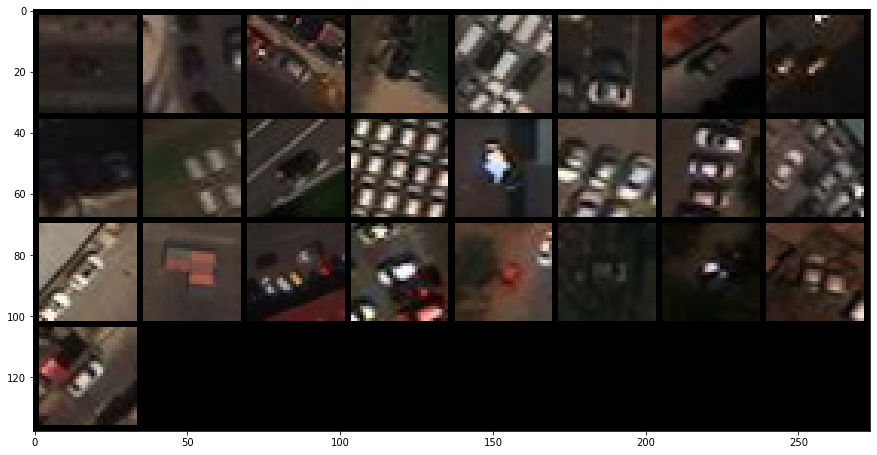

In [11]:
def show(img):
    npimg = img.numpy()
    plt.figure(figsize=[15,10])
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
show(img_grid)

In [12]:
train_size = 0.7*len(dataset)
val_size = 0.3*len(dataset)
print("full size",len(dataset))
print("train size",train_size)
print("val size",val_size)
189829+81355

full size 271184
train size 189828.8
val size 81355.2


271184

In [13]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        
def plot_classes_preds(images, labels):
    
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(10, 10))
    for idx in np.arange(len(images)):
        ax = fig.add_subplot(5, 5, idx+1, xticks=[], yticks=[])
        ax.set_title(id2label[idx_to_class[labels[idx].item()]])
        matplotlib_imshow(images[idx])
    return fig
#writer = SummaryWriter('runs/Object_detection_experiment_'+str(np.random.randint(0,1000)),flush_secs=1)
#writer.add_figure('Images and labels', plot_classes_preds(images, labels))

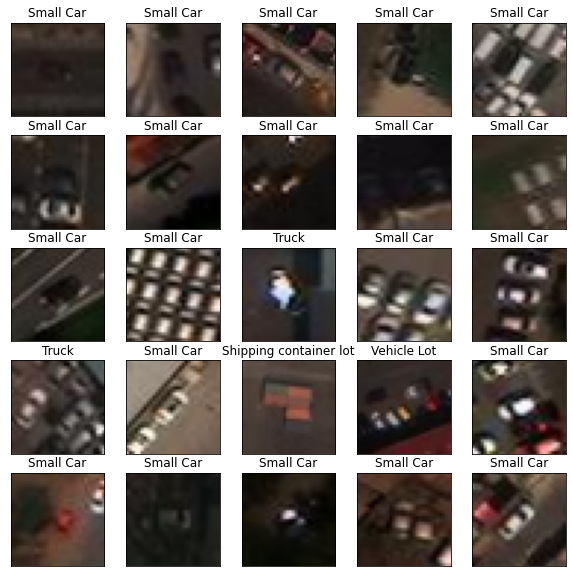

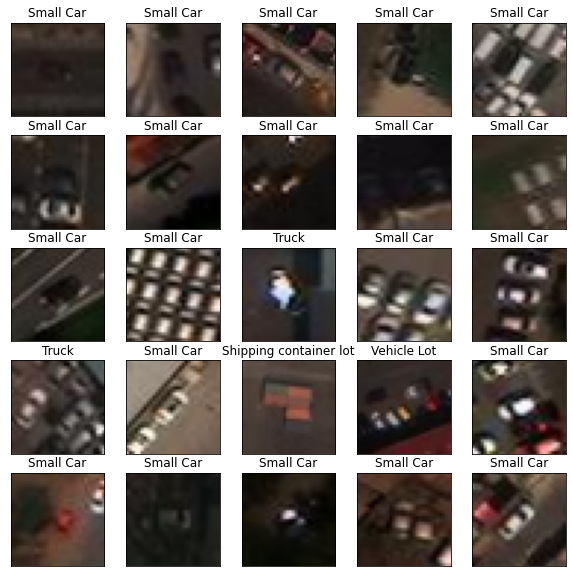

In [14]:
plot_classes_preds(images, labels)

In [46]:
total_num_of_images = 0
class_counts = {}
for subdir, dirs, files in os.walk(data_dir+'train_images_24classes'):
    if len(files)>0:
        print(f'{id2label.get(subdir[-2:],-1):>25} {len(files):>10}')
        class_counts[id2label.get(subdir[-2:],-1)] = len(files)
        total_num_of_images+=len(files)
print(total_num_of_images)

              Cargo Truck       5852
              Vehicle Lot       3185
                Cargo Car       1820
             Pickup Truck       1096
              Truck w/Box       3591
                     Shed       1145
         Damaged Building       1026
               Dump Truck       1351
                 Hut/Tent        703
                      Bus       6892
            Passenger Car       1596
                Small Car     210497
             Storage Tank       1609
       Shipping Container       1574
            Truck Tractor        856
        Passenger Vehicle       2932
           Fishing Vessel        729
   Shipping container lot       1809
                Motorboat       1455
            Utility Truck       3598
          Truck w/Flatbed        887
                  Trailer       4057
                Excavator        836
                    Truck      12088
271184


In [33]:
147347+63150

210497

In [45]:
63150/81366

0.7761227048152791

In [47]:
81366/271184

0.3000398253584282

In [ ]:
c_count = pd.DataFrame(list(class_counts.values()))
c_count[c_count[0]>700].values[1:]
small_subset_class = {}
a = 0
for label, count in class_counts.items():
    
    if count > 700 and count < 250000:
        small_subset_class[label] = count
        #print(label,count)
        a+=count
print("total",a)
print(small_subset_class)
print("total confirm",sum(list(small_subset_class.values())))
print("len",len(small_subset_class))
#save('class_counts_24classes.pkl',small_subset_class)

In [ ]:
new_classes = load('class_counts_24classes.pkl')
#os.mkdir(data_dir+'train_images_24classes')
# for i in list(new_classes.keys()):
#     os.mkdir(data_dir+'train_images_24classes/'+str(int(label2id[i])))

In [ ]:
a

In [23]:
np.round(2.3444,2)

2.34

In [ ]:
label2id

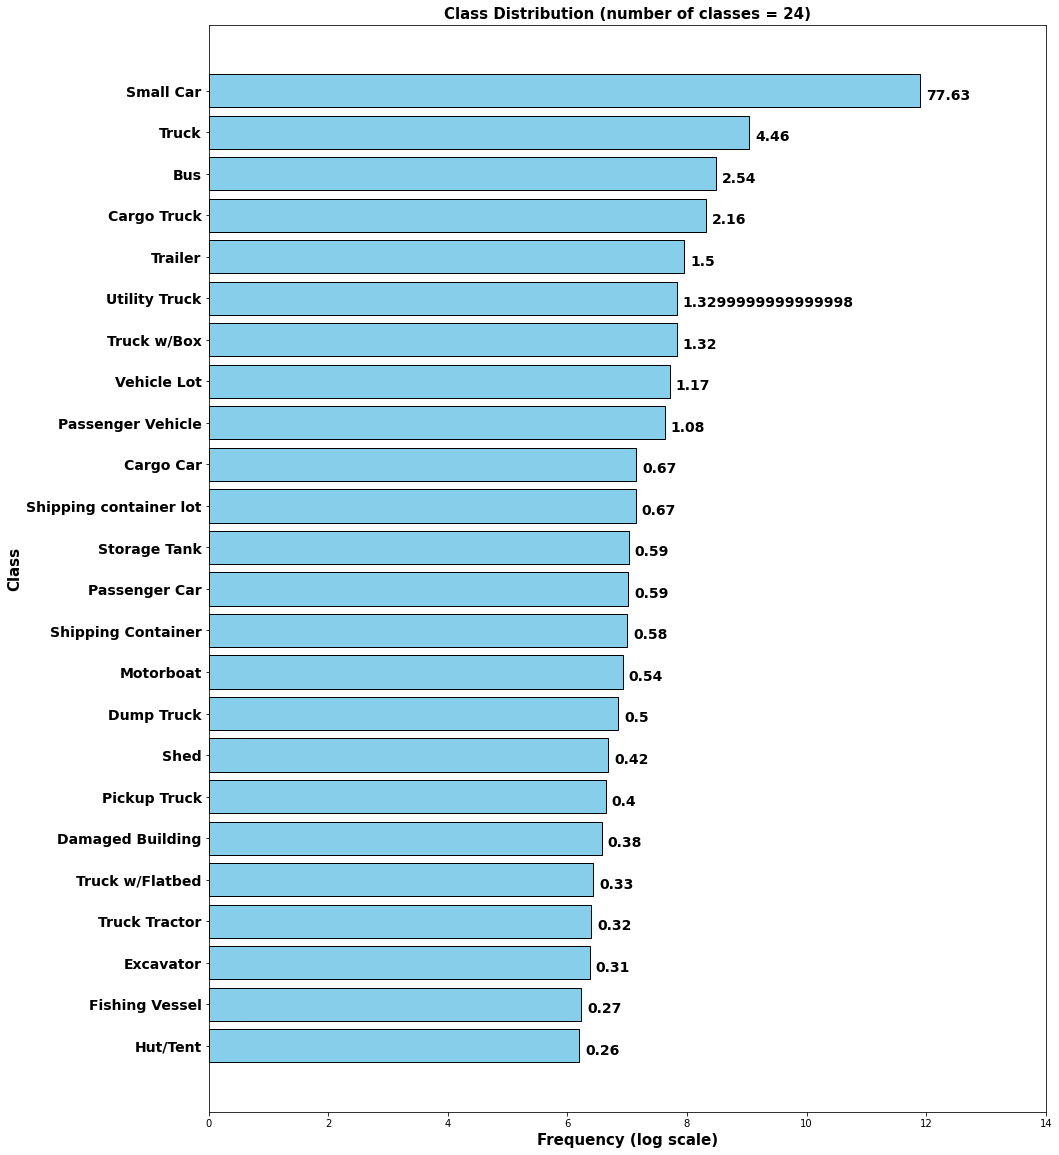

In [43]:
fig, ax = plt.subplots(figsize=[15,20])
class_counts = sorted(class_counts.items(), key=lambda class_counts: class_counts[1])
class_counts = {k: v for k, v in class_counts}
real_count = list(class_counts.values())
total_count = np.sum(real_count)
bars = plt.barh(list(class_counts.keys()), np.log(np.array(list(class_counts.values()))), edgecolor='k',color='skyblue')

for i,bar in enumerate(bars): 
    width = bar.get_width() +0.1
    label_y_pos = bar.get_y() + 0.2 + bar.get_height() // 2
    #ax.text(width,label_y_pos, s=f'{real_count[i]}',fontweight='bold',fontdict={'fontsize':14})
    ax.text(width,label_y_pos, s=f'{np.round(1.0*real_count[i]/total_count,4)*100.0}',fontweight='bold',fontdict={'fontsize':14})
    
    if i > 44:
        bar.set_color('#8f9805')
        bar.set_edgecolor('k')

for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(14)
    tick.label1.set_fontweight('bold')

custom_lines = [Line2D([0], [0], color='#8f9805', lw=4)]
#plt.legend(custom_lines,['Top 15 most frequent classes'],loc=5,fontsize='large')
plt.title('Class Distribution (number of classes = ' + str(len(real_count))+')',fontdict={'fontsize':15,'fontweight':'bold'})
plt.xlabel('Frequency (log scale)', fontdict={'fontsize':15,'fontweight':'bold'})
plt.ylabel('Class', fontdict={'fontsize':15,'fontweight':'bold'})
plt.xlim(0,14)

plt.show()

In [ ]:
f = open('old_pixel_areas.pkl','rb')
old_pixel_areas = pickle.load(f)
plt.figure(figsize=[10,6])
plt.hist(np.log(np.array(old_pixel_areas)),bins=50,color='skyblue',ec="k")

plt.title('Histogram of pixel areas before resampling \n Total number of images = 593,091',fontdict={'fontsize':14,'fontweight':'bold'})
plt.xlabel('Frequency (log scale)', fontdict={'fontsize':14,'fontweight':'bold'})
plt.ylabel('Class', fontdict={'fontsize':14,'fontweight':'bold'})
plt.xlim(5,14)

plt.show()

In [ ]:
f = open('new_pixel_areas.pkl','rb')
new_pixel_areas = pickle.load(f)
plt.figure(figsize=[10,6])
plt.hist(np.log(np.array(new_pixel_areas)),bins=20,color='skyblue',ec="k")

plt.title('Histogram of pixel areas after resampling \n Total number of images = 581,470',fontdict={'fontsize':14,'fontweight':'bold'})
plt.xlabel('Frequency (log scale)', fontdict={'fontsize':14,'fontweight':'bold'})
plt.ylabel('Class', fontdict={'fontsize':14,'fontweight':'bold'})
plt.xlim(5,14)

plt.show()

In [19]:
import splitfolders  # or import split_folders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(data_dir+'train_images_24classes/', output=data_dir+'train_images_24classess_split', seed=1337, ratio=(.7, .3), group_prefix=None) # default values

# Split val/test with a fixed number of items e.g. 100 for each set.
# To only split into training and validation set, use a single number to `fixed`, i.e., `10`.
#splitfolders.fixed("input_folder", output="output", seed=1337, fixed=(100, 100), oversample=False, group_prefix=None) # default values

Copying files: 271184 files [00:24, 11167.64 files/s]


In [ ]:
!pwd

In [18]:
!pip install split-folders

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [20]:
data_dir+'train_images_24classess_split'

'/home/abhijit/nat/Object-Detection/data/train_images_24classess_split'

In [ ]:
splitfolders.ratio()

In [50]:
import torch.nn as nn

net = nn.Sequential(nn.Linear(20, 6), nn.Linear(6, 3))

In [52]:
net[0]

Linear(in_features=20, out_features=6, bias=True)

In [54]:
from models.resnet import resnet50

In [55]:
net = resnet50()

In [56]:
net

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2_x): Sequential(
    (0): BottleNeck(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stri

In [114]:
for name,param in net.named_parameters():
    print(name)

conv1.0.weight
conv1.1.weight
conv1.1.bias
conv2_x.0.residual_function.0.weight
conv2_x.0.residual_function.1.weight
conv2_x.0.residual_function.1.bias
conv2_x.0.residual_function.3.weight
conv2_x.0.residual_function.4.weight
conv2_x.0.residual_function.4.bias
conv2_x.0.residual_function.6.weight
conv2_x.0.residual_function.7.weight
conv2_x.0.residual_function.7.bias
conv2_x.0.shortcut.0.weight
conv2_x.0.shortcut.1.weight
conv2_x.0.shortcut.1.bias
conv2_x.1.residual_function.0.weight
conv2_x.1.residual_function.1.weight
conv2_x.1.residual_function.1.bias
conv2_x.1.residual_function.3.weight
conv2_x.1.residual_function.4.weight
conv2_x.1.residual_function.4.bias
conv2_x.1.residual_function.6.weight
conv2_x.1.residual_function.7.weight
conv2_x.1.residual_function.7.bias
conv2_x.2.residual_function.0.weight
conv2_x.2.residual_function.1.weight
conv2_x.2.residual_function.1.bias
conv2_x.2.residual_function.3.weight
conv2_x.2.residual_function.4.weight
conv2_x.2.residual_function.4.bias
con

In [117]:
list(net.children())[-1].named

Linear(in_features=2048, out_features=100, bias=True)

In [83]:
net.train()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2_x): Sequential(
    (0): BottleNeck(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stri

In [97]:
input_tensor = torch.Tensor(10, 3, 64, 64)

In [112]:
net = net.cuda()
output = net(input_tensor)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [99]:
a, b = output.max(1)

In [102]:
b.tolist()

[21, 21, 21, 21, 21, 21, 21, 21, 21, 21]

In [103]:
f = []

In [104]:
f.extend(b.tolist())

In [105]:
f

[21, 21, 21, 21, 21, 21, 21, 21, 21, 21]

In [106]:
images, labels = next(iter(trainloader))

In [109]:
images.shape

torch.Size([25, 3, 32, 32])

In [110]:
labels

tensor([ 1,  1,  1,  2,  1,  5,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1, 22,  1,  1,  1,  1,  1])

In [111]:
labels.tolist()

[1, 1, 1, 2, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 22, 1, 1, 1, 1, 1]

In [113]:
!nvidia-msi

/bin/sh: 1: nvidia-msi: not found
